In [14]:
import os, sys, gc
from os.path import expanduser
from collections import defaultdict
import numpy as np
from scipy import spatial
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

user_home = expanduser("~")
neuron_home = '%s/bin/nrnpython3/lib/python' % user_home
model_home = '%s/src/model' % user_home
dentate_home = '%s/dentate' % model_home
datasets_home = '/media/igr/d865f900-7fcd-45c7-a7a7-bd2a7391bc40/Data/DG/'
results_prefix = os.getenv('DG_RESULTS_DIR', '%s/results' % datasets_home)
sys.path.append(neuron_home) 
sys.path.append(model_home) 

import neuroh5
from neuroh5.io import read_population_ranges, read_population_names, read_cell_attributes, read_cell_attribute_selection
import dentate
from dentate import utils, plot, stimulus, spikedata, network_clamp
from dentate.env import Env
from dentate.utils import Struct, zip_longest

In [2]:
bin_size = 5.
config_path = '%s/config/Full_Scale_Basis.yaml' % dentate_home
template_path = '%s/templates' % dentate_home
                          
rel_input_features_path = 'Full_Scale_Control/DG_input_features_20191119_compressed.h5'
input_features_path = '%s/%s' % (datasets_home, rel_input_features_path)
input_features_namespace_id = 'Place Selectivity A'

arena_id = 'A'
trajectory_id = 'Diag'

input_spikes_path = '%s/Full_Scale_Control/DG_input_spike_trains_20191119_compressed.h5' % datasets_home

In [3]:
baks_config = Struct(**{'BAKS Alpha': 4.77,'BAKS Beta': None})
pf_config = Struct(**{'Minimum Width': 15., 'Minimum Rate': 1.0})

env = None
if config_path is not None:
    env = Env(config_file=config_path, template_paths=template_path)
    if env.analysis_config is not None:
        baks_config.update(env.analysis_config['Firing Rate Inference'])
        pf_config.update(env.analysis_config['Place Fields'])



In [4]:
def pf_dist(reference, result):
    dists = []
    for i in range(result.shape[0]):
        dists_i = []
        for j in range(reference.shape[0]):
            dist = np.linalg.norm(result[i, :] - reference[j, :])
            dists_i.append(dist)
        dists.append(np.min(np.asarray(dists_i)))
    return np.mean(dists)
        
    

In [5]:
## Identify proximal-field and distal-field cells relative to the trajectory of interest
def classify_fields(input_features_path, input_features_namespace_id, population, query_diam):
    input_features = {}
    proximal_field = set([])
    distal_field = set([])
    it = read_cell_attributes(input_features_path, population, namespace=input_features_namespace_id,
                              mask=set(['X Offset', 'Y Offset', 'Field Width']))
    for itercount, (key, item) in enumerate(it):
        input_features[key] = item
        x_offsets = item['X Offset']
        y_offsets = item['Y Offset']
        widths = item['Field Width']
        for i in range(len(x_offsets)):
            x = x_offsets[i]
            y = y_offsets[i]
            w = widths[i]
            q = trajectory_si.query_ball_point([x, y], r=1.01 * (query_diam / 2.))
            
            if len(q) > 0:
                if itercount == 0:
                    print('%f %f (%f): ' % (x, y, w), [np.linalg.norm(np.asarray([x,y]) - trajectory_si.data[ind]) for ind in q])
                input_features[key]['X Offset'] = np.asarray([x], dtype=np.float32)
                input_features[key]['Y Offset'] = np.asarray([y], dtype=np.float32)
                input_features[key]['Field Width'] = np.asarray([w], dtype=np.float32)
                proximal_field.add(key)
                if key in distal_field:
                    distal_field.remove(key)
                break
            else:
                distal_field.add(key)
    return input_features, proximal_field, distal_field

In [6]:
def field_selection(input_features, field_dict, population, nbins, bin_sample_size, spatial_bin_range=(40, 800)):
    field_keys = []
    field_xs = []
    field_ys = []
    field_ws = []
    for key in field_dict:
        item = input_features[key]
        x_offsets = item['X Offset']
        y_offsets = item['Y Offset']
        widths = item['Field Width']
        for i in range(len(x_offsets)):
            x = x_offsets[i]
            y = y_offsets[i]
            w = widths[i]
            field_keys.append(key)
            field_xs.append(x)
            field_ys.append(y)
            field_ws.append(w)

    field_inds = np.asarray(field_keys)
    field_x = np.asarray(field_xs)
    field_y = np.asarray(field_ys)
    field_w = np.asarray(field_ws)

    selection_bins = np.linspace(spatial_bin_range[0], spatial_bin_range[1], nbins)
    field_w_inds = np.digitize(field_w, selection_bins)
    field_selection_bins = []
    field_selection_w = []
    field_selection_x = []
    field_selection_y = []
    for i in range(nbins-1):
        candidates = field_inds[np.where(field_w_inds == i)]
        if len(candidates) > 0:
            selection = np.random.choice(candidates, bin_sample_size)
            field_selection_bins.append(selection)
        else:
            field_selection_bins.append(np.asarray([]))
            
    return field_selection_bins, selection_bins


In [7]:
def field_selection_info(selection_bins, input_rate_map, trj_x, trj_y):
    field_info = []
    for sbin in selection_bins:
        for s in sbin:
            bin_info = {}
            trj_rate_map = input_rate_map[s]['Trajectory Rate Map']
            rate_min_ind, rate_max_ind = np.argmin(trj_rate_map), np.argmax(trj_rate_map)
            min_xyr = (trj_x[rate_min_ind], trj_y[rate_min_ind], trj_rate_map[rate_min_ind])
            max_xyr = (trj_x[rate_max_ind], trj_y[rate_max_ind], trj_rate_map[rate_max_ind])
            bin_info[s] = (min_xyr, max_xyr)
            field_info.append(bin_info)
    return field_info

In [8]:
def plot_selection_bins(input_features, field_selection_bins, trj_x, trj_y):

    fig, ax = plt.subplots(figsize=(16, 16),)

    ax.plot(trj_x, trj_y, 'r')
    circles = []
    
    for sbin in field_selection_bins:
      
        for s in sbin:
    
            w = input_features[s]['Field Width']
            x = input_features[s]['X Offset']
            y = input_features[s]['Y Offset']
            for i in range(len(x)):
                circles.append(plt.Circle((x[i],y[i]), radius=w[i]/2.))

    cc = mpl.collections.PatchCollection(circles, alpha=0.3)
    ax.add_collection(cc)

    ax.set_xlim(-200, 200)
    ax.axis("equal")
    plt.show()
    
    return ax

In [9]:
trj_x, trj_y, trj_d, trj_t = stimulus.read_trajectory(input_spikes_path, arena_id, trajectory_id)
trajectory_si = spatial.cKDTree(np.column_stack((trj_x, trj_y)))


In [10]:
query_diam = 10. # cm
## Identify proximal-field and distal-field cells relative to the trajectory of interest
GC_input_features, GC_proximal_field, GC_distal_field = classify_fields(input_features_path, input_features_namespace_id, 'GC', query_diam)
print(len(GC_proximal_field))
print(len(GC_distal_field))
LPP_input_features, LPP_proximal_field, LPP_distal_field = classify_fields(input_features_path, input_features_namespace_id, 'LPP', query_diam)
print(len(LPP_proximal_field))
print(len(LPP_distal_field))

11480
185421
2676
15513


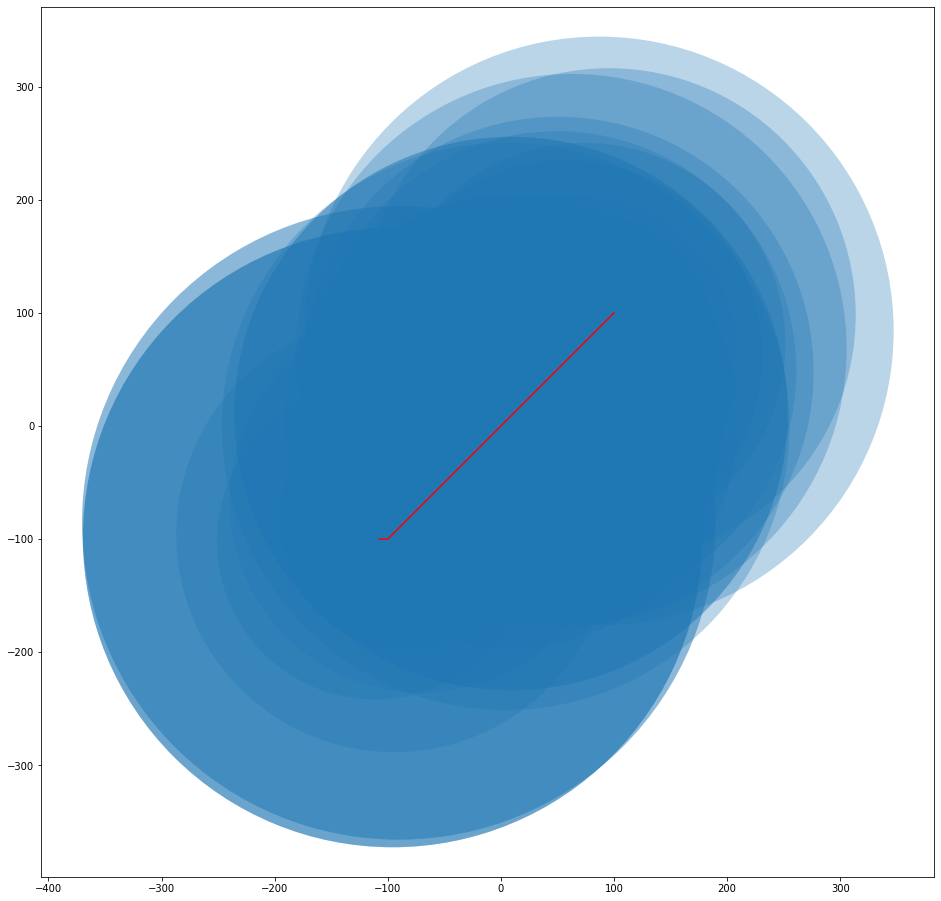

In [11]:
population = 'GC'
nbins = 10
bin_sample_size = 5
## separate field widths into `nbins` bins and select `bin_sample_size` cells for each bin
GC_proximal_field_selection = field_selection(GC_input_features, GC_proximal_field, population, nbins, bin_sample_size)
GC_distal_field_selection = field_selection(GC_input_features, GC_distal_field, population, nbins, bin_sample_size)
plot_selection_bins(GC_input_features, GC_proximal_field_selection[0], trj_x, trj_y)


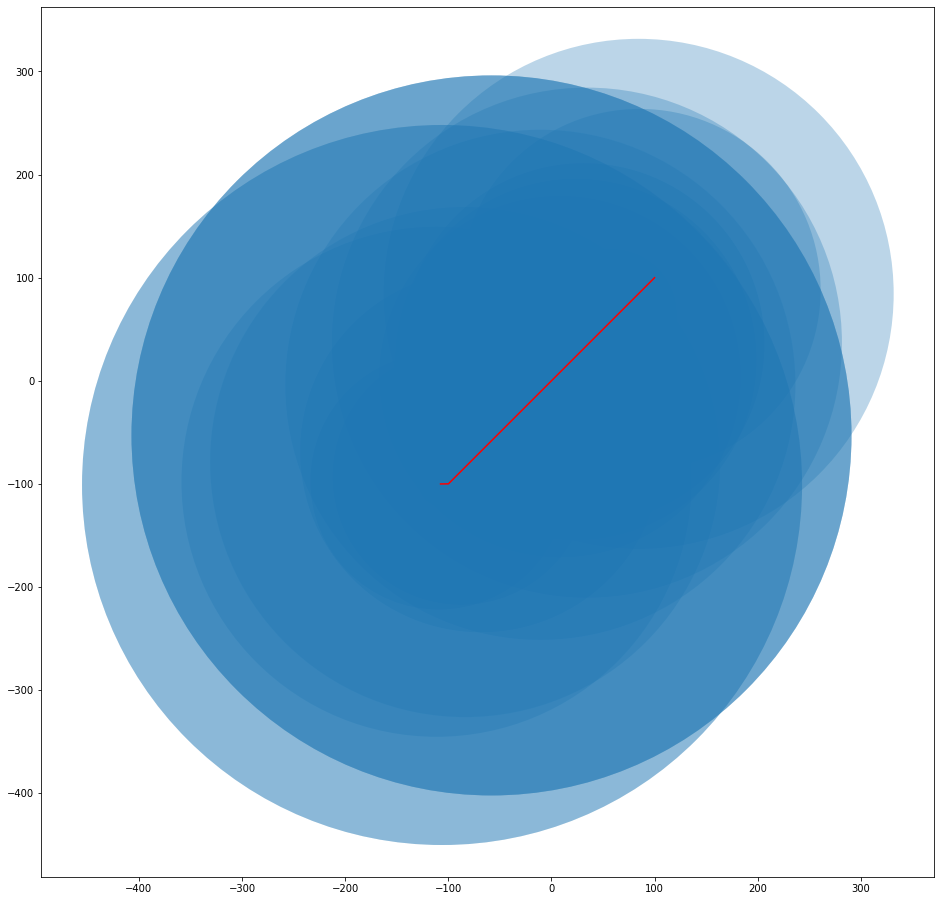

([array([1103183, 1100224, 1096197, 1097439, 1098090]), array([1103916, 1099663, 1097908, 1101219, 1100909]), array([1107906, 1112320, 1107596, 1113923, 1108117]), array([1117728, 1115336, 1122419, 1122551, 1121501]), array([1124056, 1126240, 1116594, 1118412, 1126049]), array([], dtype=float64), array([1117314, 1119781, 1126063, 1119999, 1123484]), array([], dtype=float64), array([1127820, 1126878, 1126878, 1127820, 1127820])], array([ 40.        , 124.44444444, 208.88888889, 293.33333333,
       377.77777778, 462.22222222, 546.66666667, 631.11111111,
       715.55555556, 800.        ]))


In [12]:
population = 'LPP'
nbins = 10
bin_sample_size = 5
## separate field widths into `nbins` bins and select `bin_sample_size` cells for each bin
LPP_proximal_field_selection = field_selection(LPP_input_features, LPP_proximal_field, population, nbins, bin_sample_size)
LPP_distal_field_selection = field_selection(LPP_input_features, LPP_distal_field, population, nbins, bin_sample_size)
plot_selection_bins(LPP_input_features, LPP_proximal_field_selection[0], trj_x, trj_y)
print(LPP_proximal_field_selection)

In [22]:
input_namespace = '%s %s %s' % ('Input Spikes', arena_id, trajectory_id)
LPP_input_rate_map = dict(read_cell_attribute_selection(input_spikes_path, 'LPP', 
                                               namespace=input_namespace, 
                                               selection=[s for sbin in LPP_proximal_field_selection[0] for s in sbin],
                                               mask=set(['Trajectory Rate Map'])))
gc.collect()
GC_input_rate_map = dict(read_cell_attribute_selection(input_spikes_path, 'GC', 
                                               namespace=input_namespace,
                                               selection=[s for sbin in GC_proximal_field_selection[0] for s in sbin],
                                               mask=set(['Trajectory Rate Map'])))
gc.collect()                                    

0

In [23]:
LPP_proximal_field_selection_info = field_selection_info(LPP_proximal_field_selection[0], LPP_input_rate_map, trj_x, trj_y)
print(LPP_proximal_field_selection_info)
GC_proximal_field_selection_info = field_selection_info(GC_proximal_field_selection[0], GC_input_rate_map, trj_x, trj_y)
print(GC_proximal_field_selection_info)


[{1103183: ((-107.5, -100.0, 0.0), (73.96948, 73.96948, 16.66429))}, {1100224: ((-107.5, -100.0, 0.0), (11.517811, 11.517811, 9.910494))}, {1096197: ((-107.5, -100.0, 0.0), (42.213314, 42.213314, 18.145046))}, {1097439: ((-107.5, -100.0, 0.0), (-64.27696, -64.27696, 19.650038))}, {1098090: ((-107.5, -100.0, 0.0), (-68.43475, -68.43475, 19.999708))}, {1103916: ((-107.5, -100.0, 0.0), (-59.907047, -59.907047, 19.41026))}, {1099663: ((-107.5, -100.0, 0.0), (-70.66214, -70.66214, 19.023222))}, {1097908: ((-107.5, -100.0, 0.0), (-90.98439, -90.98439, 19.68136))}, {1101219: ((-107.5, -100.0, 0.0), (-31.73591, -31.73591, 19.957973))}, {1100909: ((-107.5, -100.0, 0.0), (44.97103, 44.97103, 19.157907))}, {1107906: ((-107.5, -100.0, 0.0), (61.623398, 61.623398, 19.559038))}, {1112320: ((-107.5, -100.0, 0.0), (20.787981, 20.787981, 19.998827))}, {1107596: ((-107.5, -100.0, 0.0), (-65.783104, -65.783104, 19.734606))}, {1113923: ((-107.5, -100.0, 0.0), (-22.953646, -22.953646, 19.999943))}, {110811